In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

import sys
sys.path.append("..")
from utils import (
    DATA_PATH,
    version,
    geo_slices,
    slice_tropics,
    dense_vegetation,
    compute_area_hectares
)

terra = rio.open(DATA_PATH + "/terraaqua.tif", 'r').read(1)
cmap_terra = colors.ListedColormap(['white', '#D7D7D7FF'])

In [2]:
# Function to make a shifted colormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. 
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = colors.LinearSegmentedColormap(name, cdict)
    return newcmap

In [3]:
# Figure 1

In [4]:
# read TSM 2020 map
tsm_2020_map = np.load(DATA_PATH + f"/outputs/TSM_2020{version}.npy")
tsm_2020_map.shape

(7794, 32198)

In [5]:
# read Linear Regression TSM map
lr_tsm_map = np.load(DATA_PATH + '/outputs/LinearRegression_TSM_2001_2020_v15.npy')
lr_tsm_map.shape

(7794, 32198)

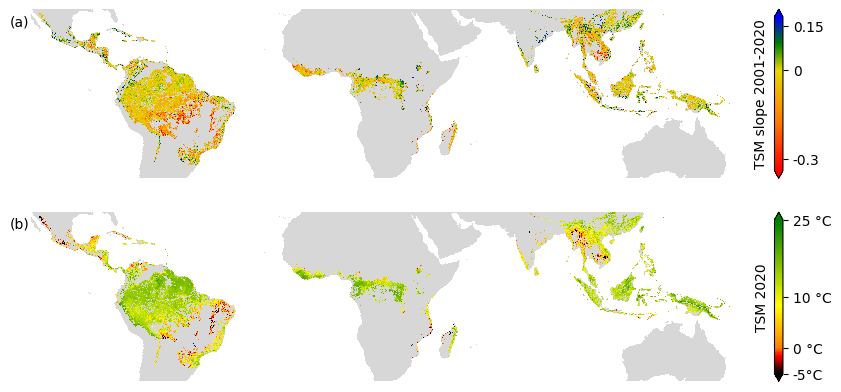

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), gridspec_kw={'left': 0.05, 'right': 0.95, 'top': 0.98, 'bottom': 0.05})

for ax in [ax1, ax2]:
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()

# Plot Linear Regression TSM map (figure 1a)
colors_ = [(1, 0, 0), (1,0.5,0), (0.9, 0.85, 0), (0, 0.5, 0), (0,0,1)]
cmap_lr = colors.LinearSegmentedColormap.from_list('lr_tsm', colors_, N=100)
minn = -0.34
maxx = 0.18
cmap_lr_shifted = shiftedColorMap(cmap_lr, midpoint=(-minn)/(maxx - minn), name='tsm_shifted')
cmap_lr_shifted.set_bad(alpha=0)
im = ax1.imshow(lr_tsm_map, cmap=cmap_lr_shifted, interpolation='none')
im.set_clim(minn, maxx)
# keep map rasterized
ax1.set_rasterization_zorder(0) 
im.set_zorder(0)
im.set_rasterized(True) 
# color bar
cbar = fig.colorbar(im, extend='both', shrink=1, ticks = [-0.3, 0, 0.15], format= mticker.FixedFormatter([-0.3,0,0.15]),)
cbar.ax.set_ylabel('TSM slope 2001-2020', rotation=90, labelpad=-50, fontdict={'fontsize': 10})
ax1.text(-0.03, 0.97, '(a)', transform=ax1.transAxes,fontsize=10, va='top', ha='left')

# Plot TSM 2020 map (figure 1b)
colors_ = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 0.5, 0)]
cmap_tsm = colors.LinearSegmentedColormap.from_list('tsm', colors_, N=100)
minn = -5
maxx = 25
cmap_tsm_shifted = shiftedColorMap(cmap_tsm, midpoint=(-minn)/(maxx - minn), name='tsm_shifted')
cmap_tsm_shifted.set_bad(alpha=0)
im = ax2.imshow(tsm_2020_map, cmap=cmap_tsm_shifted, interpolation='none')
im.set_clim(minn, maxx)
# keep map rasterized
ax2.set_rasterization_zorder(0) 
im.set_zorder(0)
im.set_rasterized(True) 
# colorbar
cbar = fig.colorbar(im, extend='both', shrink=1, ticks = [-5, 0, 10, 25], format= mticker.FixedFormatter([f'-5°C', '0 °C', '10 °C', f'25 °C']),)
cbar.ax.set_ylabel('TSM 2020', rotation=90, labelpad=-55, fontdict={'fontsize': 10})
ax2.text(-0.03, 0.97, '(b)', transform=ax2.transAxes,fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/TSM_figure.pdf", bbox_inches='tight')

In [ ]:
# fraction and area in hectares in SEA with TSM slope > 0
lr_tsm_sea = np.load(DATA_PATH + "/outputs/LinearRegression_TSM_2001_2020_south_east_asia__v15.npy")
tot_area = compute_area_hectares(~np.isnan(lr_tsm_sea), geo_slices['south_east_asia'])
area_pos_slope = compute_area_hectares(lr_tsm_sea > 0, geo_slices['south_east_asia'])
print(area_pos_slope * 1e-6)
print(area_pos_slope / tot_area)

163.11684928562318
0.37437930173503503


In [ ]:
# Figure S1

In [9]:
# read Tcrit map
tcrit_map = rio.open(DATA_PATH + '/outputs/Tcrit_map_mean_1981_2010_v15.tif', 'r').read(1)
print(tcrit_map.shape)
# Slice Tcrit map to tropics and mask where TSM map is masked
tcrit_map = tcrit_map[slice_tropics]
tcrit_map[np.isnan(tsm_2020_map)] = np.nan  
print(tcrit_map.shape)

(21122, 43199)
(7794, 32198)


In [ ]:
min_tcrit = rio.open(DATA_PATH + '/outputs/Tcrit_map_min_1981_2010_v15.tif', 'r').read(1)
min_tcrit = min_tcrit[slice_tropics]
min_tcrit[np.isnan(tsm_2020_map)] = np.nan  
# max_tcrit = rio.open(DATA_PATH + '/outputs/Tcrit_map_max_1981_2010_v15.tif', 'r').read(1)
# max_tcrit = max_tcrit[slice_tropics]
# max_tcrit[np.isnan(tsm_2020_map)] = np.nan  
delta_tcrit = tcrit_map - min_tcrit

In [ ]:
print(np.nanmin(tcrit_map), np.nanquantile(tcrit_map, (0.05,0.95)), np.nanmax(tcrit_map))
print(np.nanmin(min_tcrit), np.nanquantile(min_tcrit, (0.05,0.95)), np.nanmax(min_tcrit))
# print(np.nanmin(max_tcrit), np.nanquantile(max_tcrit, (0.05,0.95)), np.nanmax(max_tcrit))
print(np.nanmin(delta_tcrit), np.nanquantile(delta_tcrit, (0.05,0.95)), np.nanmax(delta_tcrit))

38.59 [43.21454397 47.84736708] 54.9583636836448
31.05 [38.59 45.6 ] 54.9583636836448
38.59 [44.3        54.95836368] 54.9583636836448
0.0 [0.         8.29015825] 15.68106270224106


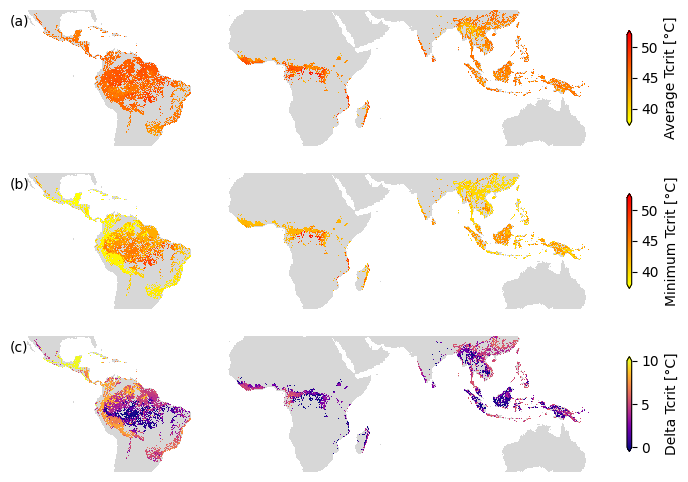

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(10,6))

tcrit_minn = 38
tcrit_maxx = 52
tcrit_cmap = colors.LinearSegmentedColormap.from_list("tcrit", ["yellow", "red"])
delta_minn = 0
delta_maxx = 10

for ax, data, cmap, minn, maxx, ylab, abc in zip(
    axs, [tcrit_map, min_tcrit, delta_tcrit], [tcrit_cmap, tcrit_cmap, 'plasma'], [tcrit_minn, tcrit_minn, delta_minn], [tcrit_maxx, tcrit_maxx, delta_maxx], 
    ['Average Tcrit [°C]', 'Minimum Tcrit [°C]', 'Delta Tcrit [°C]'], ['(a)','(b)','(c)']):

    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    im = ax.imshow(data, cmap=cmap, interpolation='none')
    im.set_clim(minn, maxx)
    ax.set_axis_off()
    # keep map rasterized
    ax.set_rasterization_zorder(0) 
    im.set_zorder(0)
    im.set_rasterized(True) 

    cbar = fig.colorbar(im, extend='both', shrink=0.7)#, ticks = [40, 45, 50, 55],
        # format= mticker.FixedFormatter(['40°C', '45 °C', '50 °C', '55°C']))
    cbar.ax.set_ylabel(ylab, rotation=90, fontdict={'fontsize': 10}) #labelpad=-45,

    ax.text(-0.03, 0.97, abc, transform=ax.transAxes,fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/Tcrit_mean_min_delta.pdf", bbox_inches='tight')

In [6]:
# Figure 2

In [32]:
df_median_tsm_mean_tcrit = pd.DataFrame({'year': range(2001, 2021)})
df_area_neg_tsm_mean_tcrit = pd.DataFrame({'year': range(2001, 2021)})

df_median_tsm_min_tcrit = pd.DataFrame({'year': range(2001, 2021)})
df_area_neg_tsm_min_tcrit = pd.DataFrame({'year': range(2001, 2021)})

for continent, slice in geo_slices.items():
    tsm_mean_tcrit = np.load(DATA_PATH + f"/outputs/TSM_2001_2020_{continent}__v15.npy")
    df_median_tsm_mean_tcrit[continent] = np.nanmedian(tsm_mean_tcrit, axis=(0,1))

    area_tsm_neg_mean_tcrit = [compute_area_hectares(tsm_mean_tcrit[...,i] <= 0, slice) for i in range(20)]
    tot_area_mean_tcrit = compute_area_hectares(~np.isnan(tsm_mean_tcrit[...,0]), slice)
    df_area_neg_tsm_mean_tcrit[f"hectares_{continent}"] = area_tsm_neg_mean_tcrit
    df_area_neg_tsm_mean_tcrit[f"frac_{continent}"] = area_tsm_neg_mean_tcrit/tot_area_mean_tcrit*100

    tsm_min_tcrit = np.load(DATA_PATH + f"/outputs/TSM_minTcrit_2001_2020_{continent}__v15.npy")
    df_median_tsm_min_tcrit[continent] = np.nanmedian(tsm_min_tcrit, axis=(0,1))

    area_tsm_neg_min_tcrit = [compute_area_hectares(tsm_min_tcrit[...,i] <= 0, slice) for i in range(20)]
    tot_area_min_tcrit = compute_area_hectares(~np.isnan(tsm_min_tcrit[...,0]), slice)
    df_area_neg_tsm_min_tcrit[f"hectares_{continent}"] = area_tsm_neg_min_tcrit
    df_area_neg_tsm_min_tcrit[f"frac_{continent}"] = area_tsm_neg_min_tcrit/tot_area_min_tcrit*100


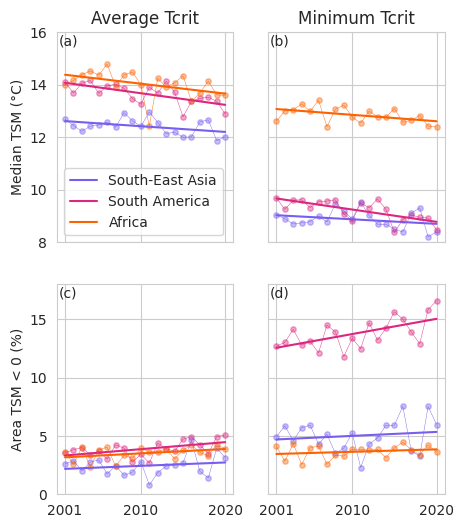

In [ ]:
sns.set_style('whitegrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(5,6), sharex=True, sharey='row')
x = np.arange(2001, 2021)
X = x.reshape(-1,1)

for ax, df in zip([ax1, ax2], [df_median_tsm_mean_tcrit, df_median_tsm_min_tcrit]):
    # ax1: median TSM for mean Tcrit
    # ax2: median TSM for min Tcrit
    for continent, color in zip(geo_slices.keys(), ['#785EF0', '#DC267F','#FE6100']):
        y = df[continent].values
        model = LinearRegression().fit(X, y)
        pred = model.predict(X)
        ax.scatter(x, y, color=color, edgecolor=None, s=15, alpha=0.4, label="_nolegend_")
        ax.plot(x, y, color=color, linewidth=0.3, label="_nolegend_")
        ax.plot(x, pred, color=color, linewidth=1.5, label=continent)
    ax.set(xticks=[2001, 2010, 2020], ylim=(8, 16), xlabel=None)
ax1.set_ylabel('Median TSM (°C)')
ax1.set_title('Average Tcrit')
ax2.set_title('Minimum Tcrit')
ax1.legend(['south_america', 'africa', 'south_east_asia'], labels=['South America', 'Africa', 'South-East Asia'])

for ax, df in zip([ax3, ax4], [df_area_neg_tsm_mean_tcrit, df_area_neg_tsm_min_tcrit]):
    # ax3: area TSM < 0 for mean Tcrit
    # ax4: area TSM < 0 for min Tcrit
    for continent, color in zip(geo_slices.keys(), ['#785EF0', '#DC267F','#FE6100']):
        y = df[f"frac_{continent}"].values
        # model = make_pipeline(PolynomialFeatures(4), Ridge(alpha=1e-5)).fit(X, y)
        model = LinearRegression().fit(X, y)
        pred = model.predict(X)
        ax.scatter(x, y, color=color, edgecolor=None, s=15, alpha=0.4)
        ax.plot(x, y, color=color, linewidth=0.3)
        ax.plot(x, pred, color=color, linewidth=1.5)
        ax.set(ylim=(0,18))
ax3.set(ylabel='Area TSM < 0 (%)')

for ax, abc in zip([ax1, ax2, ax3, ax4], ['(a)', '(b)', '(c)', '(d)']):
    ax.text(0.01, 0.99, abc, transform=ax.transAxes,fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/TSM_area_curves_mean_min_tcrit.pdf", bbox_inches='tight')
plt.show()

In [16]:
# Calculate the change in median TSM from 2001 to 2020 (°C per year)
# with mean Tcrit
print((df_median_tsm_mean_tcrit[df_median_tsm_mean_tcrit['year'] == 2020].iloc[0,1:] - df_median_tsm_mean_tcrit[df_median_tsm_mean_tcrit['year'] == 2001].iloc[0,1:]) / 19)
# with min Tcrit
print((df_median_tsm_min_tcrit[df_median_tsm_min_tcrit['year'] == 2020].iloc[0,1:] - df_median_tsm_min_tcrit[df_median_tsm_min_tcrit['year'] == 2001].iloc[0,1:]) / 19)

south_east_asia   -0.034951
south_america     -0.064145
africa            -0.021793
dtype: float64
south_east_asia   -0.033717
south_america     -0.064145
africa            -0.011513
dtype: float64


In [ ]:
# average difference in TSM between average and minimum Tcrit
(df_median_tsm_mean_tcrit - df_median_tsm_min_tcrit).mean()

year               0.000000
south_east_asia    3.542969
south_america      4.429688
africa             1.179688
dtype: float64

In [51]:
# differences in area TSM < 0 in hectares with mean Tcrit
print(df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2020].iloc[0,[1,3,5]] - df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2001].iloc[0,[1,3,5]])
print(df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2001].iloc[0,[1,3,5]])
print(df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2020].iloc[0,[1,3,5]])

hectares_south_east_asia    2.397255e+06
hectares_south_america      1.189505e+07
hectares_africa             4.372951e+05
dtype: float64
hectares_south_east_asia    1.129366e+07
hectares_south_america      2.747467e+07
hectares_africa             6.622597e+06
Name: 0, dtype: float64
hectares_south_east_asia    1.369091e+07
hectares_south_america      3.936972e+07
hectares_africa             7.059892e+06
Name: 19, dtype: float64


In [52]:
# differences in area TSM < 0 in percent with mean Tcrit
print(df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2020].iloc[0,[2,4,6]] - df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2001].iloc[0,[2,4,6]])
print(df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2001].iloc[0,[2,4,6]])
print(df_area_neg_tsm_mean_tcrit[df_area_neg_tsm_mean_tcrit.year == 2020].iloc[0,[2,4,6]])

frac_south_east_asia    0.550208
frac_south_america      1.538550
frac_africa             0.239622
dtype: float64
frac_south_east_asia    2.592075
frac_south_america      3.553676
frac_africa             3.628939
Name: 0, dtype: float64
frac_south_east_asia    3.142283
frac_south_america      5.092226
frac_africa             3.868561
Name: 19, dtype: float64


In [53]:
# differences in area TSM < 0 in hectares with min Tcrit
print(df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2020].iloc[0,[1,3,5]] - df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2001].iloc[0,[1,3,5]])
print(df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2001].iloc[0,[1,3,5]])
print(df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2020].iloc[0,[1,3,5]])


hectares_south_east_asia    4.847459e+06
hectares_south_america      3.224312e+07
hectares_africa            -1.326371e+06
dtype: float64
hectares_south_east_asia    2.231092e+07
hectares_south_america      1.051936e+08
hectares_africa             1.022220e+07
Name: 0, dtype: float64
hectares_south_east_asia    2.715838e+07
hectares_south_america      1.374367e+08
hectares_africa             8.895828e+06
Name: 19, dtype: float64


In [ ]:
# differences in area TSM < 0 in percent with min Tcrit
print(df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2020].iloc[0,[2,4,6]] - df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2001].iloc[0,[2,4,6]])
print(df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2001].iloc[0,[2,4,6]])
print(df_area_neg_tsm_min_tcrit[df_area_neg_tsm_min_tcrit.year == 2020].iloc[0,[2,4,6]])

frac_south_east_asia    1.067222
frac_south_america      3.891396
frac_africa            -0.535486
dtype: float64
frac_south_east_asia     4.911997
frac_south_america      12.695722
frac_africa              4.126929
Name: 0, dtype: float64
frac_south_east_asia     5.979219
frac_south_america      16.587118
frac_africa              3.591443
Name: 19, dtype: float64


In [ ]:
# Figure 3

In [2]:
data = {}
for continent, slice in geo_slices.items():
    tsm_2001_2020_data = np.load(DATA_PATH + f"/outputs/TSM_2001_2020_{continent}_{version}.npy")

    data[continent] = {
        '2001': tsm_2001_2020_data[...,0].flatten(), 
        '2020': tsm_2001_2020_data[...,-1].flatten(),
        '2050': np.load(DATA_PATH + f"/outputs/TSM_2050_{continent}_{version}.npy").flatten(),
        '2050 acc.': np.load(DATA_PATH + f"/outputs/TSM_2050_acclim_{continent}_{version}.npy").flatten(),
        '2100': np.load(DATA_PATH + f"/outputs/TSM_2100_{continent}_{version}.npy").flatten(),
        '2100 acc.': np.load(DATA_PATH + f"/outputs/TSM_2100_acclim_{continent}_{version}.npy").flatten(),
    }

south_america
africa
south_east_asia


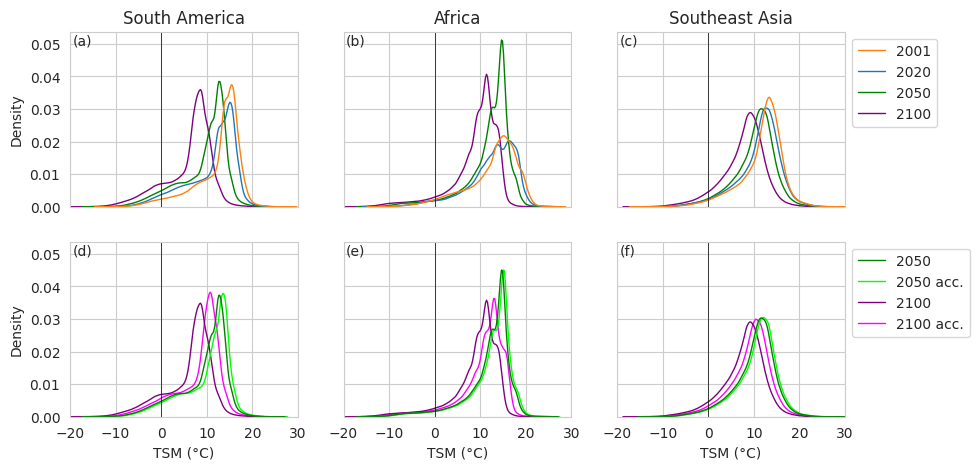

In [4]:
sns.set_style("whitegrid")
fig, (axs_top, axs_bottom) = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
colors_top = ['tab:orange', 'tab:blue', 'green', 'purple']
colors_bottom = ['green', 'lime', 'purple', 'fuchsia']

for ax1, ax2, continent, continent_title, abc_top, abc_bottom in zip(
    axs_top, axs_bottom, 
    ['south_america', 'africa', 'south_east_asia'], 
    ["South America", "Africa", "Southeast Asia"],
    ['(a)', '(b)', '(c)'], ['(d)','(e)','(f)']
):
    print(continent)
    df = pd.DataFrame(data[continent]).dropna(axis=0, how='all')
    df1 = pd.melt(df[['2001','2020','2050','2100']], var_name='year', value_name='TSM').dropna()
    df2 = pd.melt(df[['2050','2050 acc.','2100','2100 acc.']], var_name='year', value_name='TSM').dropna()

    legend = False if continent != "south_east_asia" else True
    sns.kdeplot(df1, x='TSM', hue='year', palette=colors_top, legend=legend, fill=False, linewidth=1, ax=ax1)
    sns.kdeplot(df2, x='TSM', hue='year', palette=colors_bottom, legend=legend, fill=False, linewidth=1, ax=ax2)
    
    ax1.set_title(continent_title)
    ax2.set_xlabel('TSM (°C)')
    ax1.set_xlim((-20,30))
    ax1.axvline(0, color='black', linewidth=0.5)
    ax2.axvline(0, color='black', linewidth=0.5)
    if legend:
        sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1), title=None)
        sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1), title=None)

    ax1.text(0.01, 0.99, abc_top, transform=ax1.transAxes, fontsize=10, va='top', ha='left')
    ax2.text(0.01, 0.99, abc_bottom, transform=ax2.transAxes, fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/TSM_distributions.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# Figure S2

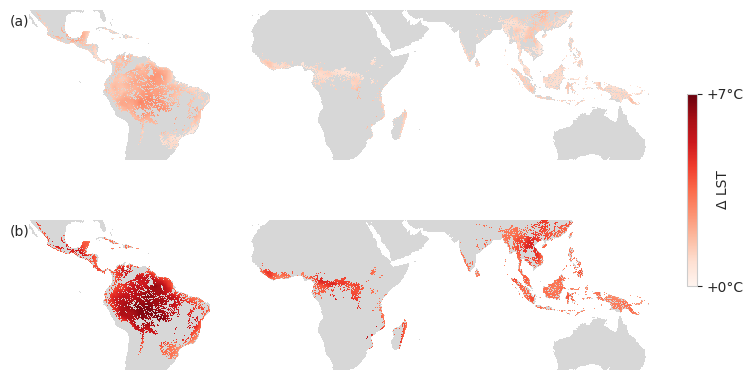

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True, sharey=True)

for ax, year, abc in zip((ax1, ax2), ['2050','2100'], ['(a)', '(b)']):
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()
    filename_delta = DATA_PATH + f"/2050-2100_temperatures/delta_tsurf_2020_{year}.tif"
    delta_tsurf = rio.open(filename_delta, 'r').read(1)[slice_tropics]
    delta_tsurf[delta_tsurf==-20] = np.nan
    # delta_tsurf[~data_both_biomes[sl]] = np.nan
    delta_tsurf[np.isnan(tsm_2020_map)] = np.nan

    im = ax.imshow(delta_tsurf, cmap=colormaps["Reds"], interpolation='none')
    im.set_clim(0, 7)

    # keep map rasterized
    ax.set_rasterization_zorder(0) 
    im.set_zorder(0)
    im.set_rasterized(True) 

    if year == '2100':
        cbar = fig.colorbar(im, ax = [ax1,ax2], shrink=0.5)
        cbar.set_ticks([0, 7])
        cbar.set_ticklabels(['+0°C', '+7°C'])
        cbar.set_label('Δ LST', fontdict={'fontsize': 10}, labelpad=-20)

    ax.text(-0.03, 0.97, abc, transform=ax.transAxes,fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/delta_LST_future_maps.pdf", bbox_inches='tight')

In [ ]:
# Figure 4

In [6]:
sps_counts_dict = {}
frac_sps_neg_tsm = {}
for year in ['2001','2020','2050','2100']:
    sps_counts = np.load(DATA_PATH + f"/outputs/species_counts_map_{year}_v15.npy")
    sps_neg_tsm_counts = np.load(DATA_PATH + f"/outputs/species_negative_tsm_counts_map_{year}_v15.npy")
   
    sps_counts = np.where(sps_counts == 0, np.nan, sps_counts)
    sps_neg_tsm_counts = np.where(np.isnan(sps_counts), np.nan, sps_neg_tsm_counts)
    sps_counts_dict[year] = sps_counts
    frac_sps_neg_tsm[year] = sps_neg_tsm_counts / sps_counts

    if year == '2050' or year == '2100':
        sps_neg_tsm_acclim_counts = np.load(DATA_PATH + f"/outputs/species_negative_tsm_counts_acclim_map_{year}_v15.npy")
        sps_neg_tsm_acclim_counts = np.where(np.isnan(sps_counts), np.nan, sps_neg_tsm_acclim_counts)
        frac_sps_neg_tsm[f"{year}_acclim"] = sps_neg_tsm_acclim_counts / sps_counts

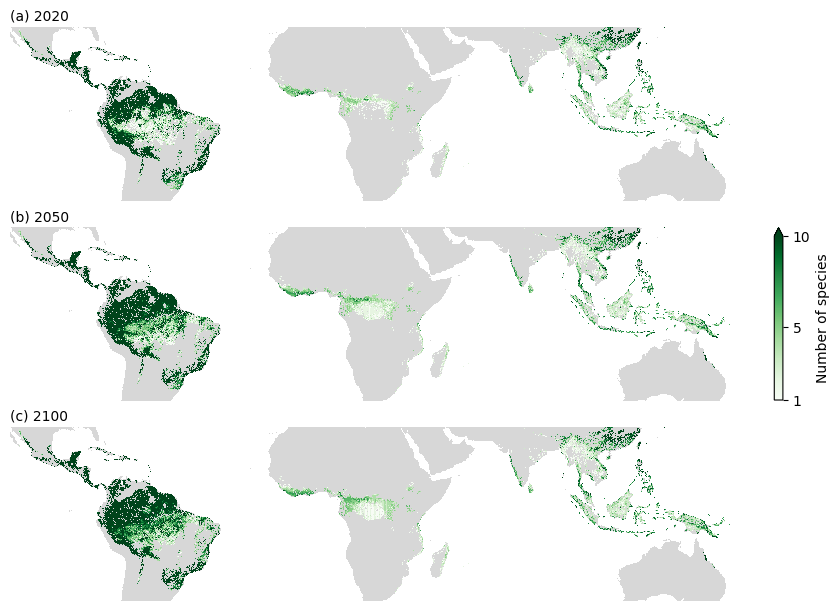

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,6), layout='constrained', sharex=True, sharey=True)

for ax, year, abc in zip((ax1, ax2, ax3), ['2020','2050','2100'], ['(a)', '(b)', '(c)']):
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()

    im = ax.imshow(sps_counts_dict[year], cmap=colormaps["Greens"], interpolation='none')
    im.set_clim(1, 10)

    # keep map rasterized
    ax.set_rasterization_zorder(0) 
    im.set_zorder(0)
    im.set_rasterized(True) 

    if year == '2100':
        cbar = fig.colorbar(im, ax = [ax1,ax2,ax3], shrink=0.3, extend='max')
        cbar.set_ticks([1, 5, 10])
        cbar.set_label('Number of species', fontdict={'fontsize': 10})

    ax.text(0, 1.1, f"{abc} {year}", transform=ax.transAxes,fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/nb_species_maps.pdf", bbox_inches='tight')

In [83]:
mean = []
n = []
non_zero_mean=[]
n_non_zero = []
mean_sps_gt_5_sa = []
n_sps_gt_5_sa = []
mean_sa = []
n_sa = []
non_zero_mean_sa=[]
n_non_zero_sa = []

for key, array in frac_sps_neg_tsm.items():
    mean.append(np.nanmean(array))
    n.append(array[~np.isnan(array)].shape[0])

    array_sa = array[:,:10000].copy()
    mean_sa.append(np.nanmean(array_sa))
    n_sa.append(array_sa[~np.isnan(array_sa)].shape[0])

    non_zero_mean_sa.append(np.nanmean(array_sa[array_sa > 0]))
    n_non_zero_sa.append(array_sa[array_sa > 0][~np.isnan(array_sa[array_sa > 0])].shape[0])

    array_sps_gt5_sa = array[:,:10000][sps_counts_dict['2020'][:,:10000] >= 5].copy()
    mean_sps_gt_5_sa.append(np.nanmean(array_sps_gt5_sa))
    n_sps_gt_5_sa.append(array_sps_gt5_sa[~np.isnan(array_sps_gt5_sa)].shape[0])

stats_df = pd.DataFrame({'year': frac_sps_neg_tsm.keys(), 'mean': mean, 'n': n, 
                         'sps_gt_5_sa_mean': mean_sps_gt_5_sa, 'n_sps_gt_5_sa': n_sps_gt_5_sa,
                         'sa_mean': mean_sa, 'n_sa': n_sa, 'sa_mean_non_zero': non_zero_mean_sa, 'n_sa_non_zero': n_non_zero_sa})

stats_df

,year,mean,n,sps_gt_5_sa_mean,n_sps_gt_5_sa,sa_mean,n_sa,sa_mean_non_zero,n_sa_non_zero
0,2001,0.038075,16764459,0.035971,7034547,0.041053,9250800,0.295756,1284090
1,2020,0.050621,16764459,0.055238,7034547,0.060390,9250800,0.331047,1687541
2,2050,0.065691,17951333,0.080982,7028940,0.084994,9818803,0.404701,2062108
3,2050_acclim,0.057878,17951333,0.070503,7028940,0.073959,9818803,0.380626,1907886
4,2100,0.121316,18001903,0.148358,7033515,0.154988,9888505,0.483088,3172501
5,2100_acclim,0.086348,18001903,0.106271,7033515,0.110446,9888505,0.445918,2449214


In [85]:
1-(stats_df.n_sa_non_zero / stats_df.n_sa)

0    0.861191
1    0.817579
2    0.789984
3    0.805691
4    0.679173
5    0.752317
dtype: float64

/tmp/ipykernel_2524245/3267292464.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(


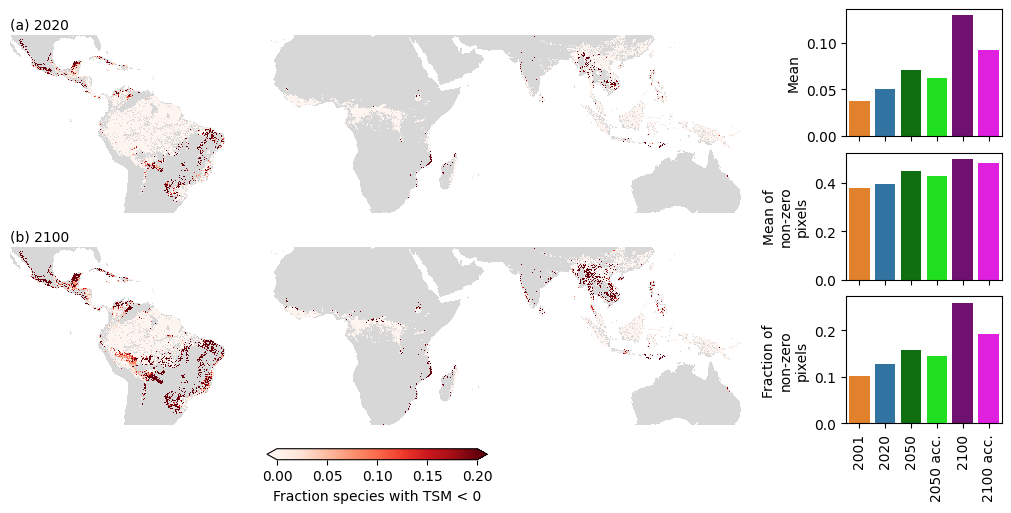

In [ ]:
fig = plt.figure(layout='constrained', figsize=(10, 5))
subfigs = fig.subfigures(1, 2, width_ratios=(2, 1))

axs_maps = subfigs[0].subplots(3, 1)
for ax, year, abc in zip(axs_maps, ['2020','2100','2100_acclim'], ['(a)','(b)','(c)']):
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()

    im = ax.imshow(frac_sps_neg_tsm[year], cmap='Reds', interpolation='none', vmin=0, vmax=0.5)
    ax.text(0, 1.1, f'{abc} {year.replace('_acclim',' acc.')}', transform=ax.transAxes,fontsize=10, va='top', ha='left')
    ax.set_rasterization_zorder(0)
    im.set_zorder(0)
    im.set_rasterized(True) 

    if year == '2100_acclim':
        cbar = fig.colorbar(im, ax = axs_maps, extend='both', shrink=0.3, orientation='horizontal')
        cbar.set_label('Fraction species with TSM < 0', fontdict={'fontsize': 10})

ax1 = subfigs[1].subplots(1,1)

# ax1, ax2, ax3 = subfigs[1].subplots(3, 1, sharex=True)
# colors = ['tab:orange', 'tab:blue', 'green', 'lime', 'purple', 'fuchsia']
# sns.barplot(stats_df, x='year', y='mean', hue='year', palette=colors, ax=ax1)
# sns.barplot(stats_df, x='year', y='non_zero_mean', hue='year', palette=colors, ax=ax2)
# g = sns.barplot(stats_df, x='year', y='frac_non_zero', hue='year', palette=colors, ax=ax3)
# g.set_xticklabels(
#     labels=['2001','2020','2050','2050 acc.','2100','2100 acc.'], rotation=90)
# ax1.set_ylabel('Mean')
# ax2.set_ylabel('Mean of\nnon-zero\npixels')
# ax3.set_ylabel('Fraction of\nnon-zero\npixels')
# ax3.set_xlabel(None)

plt.savefig("figures/resubmission/frac_species_neg_TSM.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_3489753/1359479291.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels=['2001','2020','2050','2050 acc.','2100','2100 acc.'], rotation=90)


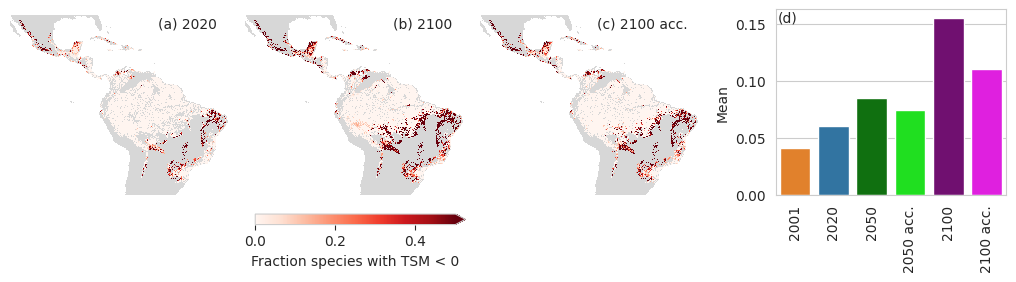

In [ ]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, layout='constrained', figsize=(10, 2.8))
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0)

for ax, year, abc in zip((ax1, ax2, ax3), ['2020','2100','2100_acclim'], ['(a)', '(b)', '(c)']):
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()
    im = ax.imshow(frac_sps_neg_tsm[year][:,:10000], cmap='Reds', interpolation='none', vmin=0, vmax=0.5)
    ax.text(0.9, 0.99, f"{abc} {year.replace('_acclim', ' acc.')}", transform=ax.transAxes,fontsize=10, va='top', ha='right')

    if year == '2100_acclim':
        cbar = fig.colorbar(im, ax = (ax1, ax2, ax3), shrink=0.3, orientation='horizontal', pad=-0.28, extend='max')
        cbar.set_label('Fraction species with TSM < 0', fontdict={'fontsize': 10})

    # keep map rasterized
    ax.set_rasterization_zorder(0) 
    im.set_zorder(0)
    im.set_rasterized(True) 

colors = ['tab:orange', 'tab:blue', 'green', 'lime', 'purple', 'fuchsia']
g = sns.barplot(stats_df, x='year', y='sa_mean', hue='year', palette=colors, ax=ax4)
g.set_xticklabels(labels=['2001','2020','2050','2050 acc.','2100','2100 acc.'], rotation=90)
g.set_yticks([0,0.05,0.1,0.15])
ax4.set_ylabel('Mean')
ax4.set_xlabel(None)
ax4.text(0.99, 0.99, f"(d)", transform=ax4.transAxes,fontsize=10, va='top', ha='right')

plt.savefig("figures/resubmission/frac_species_neg_TSM_SA.pdf", bbox_inches='tight')
# plt.show()

In [74]:
for year in ['2020','2100','2100_acclim']:
    print(year)
    print((frac_sps_neg_tsm[year][:,:10000] > 0).sum() / (~np.isnan(frac_sps_neg_tsm[year][:,:10000])).sum())
    print((frac_sps_neg_tsm[year][:,:10000] == 0).sum() / (~np.isnan(frac_sps_neg_tsm[year][:,:10000])).sum())

2020
0.18242108790591083
0.8175789120940892
2100
0.32082716244771076
0.6791728375522893
2100_acclim
0.24768294095012341
0.7523170590498766


In [82]:
for year in ['2020','2100','2100_acclim']:
    print(year)
    print(np.nanmean(frac_sps_neg_tsm[year][:,:10000][frac_sps_neg_tsm[year][:,:10000] > 0]))
    print(np.nanmean(frac_sps_neg_tsm[year][:,:10000][frac_sps_neg_tsm[year][:,:10000] >= 0]))
    print(np.nanquantile(frac_sps_neg_tsm[year][:,:10000], 0.9))

2020
0.33104691767009436
0.06038993886927704
0.1794871794871795
2100
0.4830876421872935
0.1549876374565044
0.75
2100_acclim
0.4459182849878128
0.1104463522492168
0.5


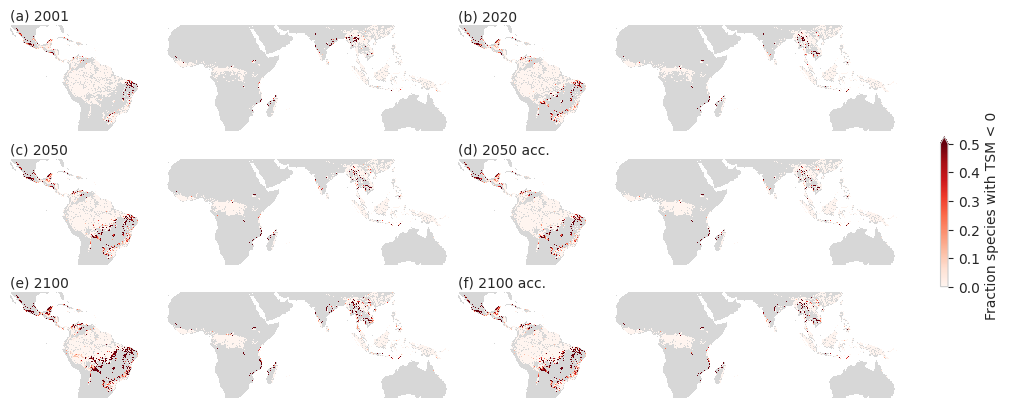

In [12]:
fig, axs = plt.subplots(3,2, layout='constrained', figsize=(10,4))

for ax, (year, data), abc in zip(axs.flatten(), frac_sps_neg_tsm.items(), ['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax.imshow(terra[slice_tropics], cmap=cmap_terra)
    ax.set_axis_off()

    im = ax.imshow(data, cmap='Reds', interpolation='none', vmin=0, vmax=0.5)
    ax.text(0, 1.15, f"{abc} {year.replace('_acclim', ' acc.')}", transform=ax.transAxes,fontsize=10, va='top', ha='left')
    if year == '2100_acclim':
        cbar = fig.colorbar(im, ax = axs.flatten(), extend='max', shrink=0.4, orientation='vertical')
        cbar.ax.set_ylabel('Fraction species with TSM < 0', fontdict={'fontsize': 10})

    # keep map rasterized
    ax.set_rasterization_zorder(0) 
    im.set_zorder(0)
    im.set_rasterized(True) 

plt.savefig("figures/resubmission/frac_species_neg_TSM_global.pdf", bbox_inches='tight')

In [63]:
xlims = [0, 10000, 21000, 32198]
df_list = []
for i, continent in enumerate(['South America', 'Africa', 'South-East Asia']):
    for year, val in frac_sps_neg_tsm.items():
        df = pd.DataFrame({'frac': val[:,xlims[i]:xlims[i+1]][val[:,xlims[i]:xlims[i+1]]!=0], 'year': year, 'continent': continent}).dropna()
        df_list.append(df)
df = pd.concat(df_list)
df

,frac,year,continent
1050385,1.000000,2001,South America
1050386,1.000000,2001,South America
1060385,1.000000,2001,South America
1060386,1.000000,2001,South America
1060387,1.000000,2001,South America
...,...,...,...
67657557,0.222222,2100_acclim,South-East Asia
67657558,0.222222,2100_acclim,South-East Asia
67657559,0.333333,2100_acclim,South-East Asia
67668758,0.200000,2100_acclim,South-East Asia


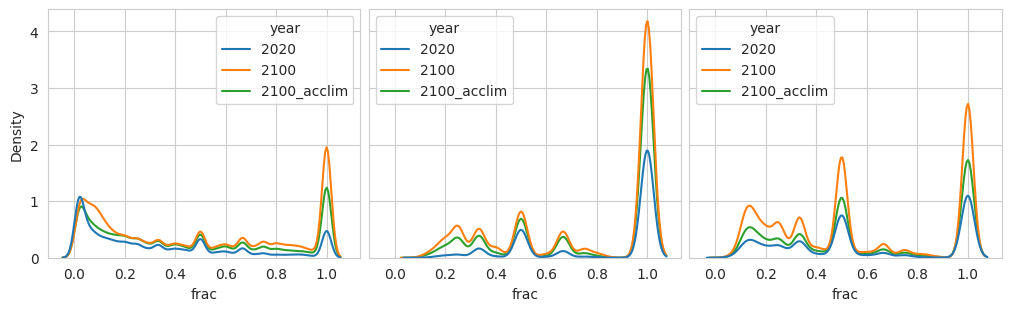

In [65]:
fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(10, 3), sharex=True, sharey=True)
xlims = [0, 10000, 21000, 32198]
for i, (ax, continent, abc) in enumerate(zip(axs, ['South America', 'Africa', 'South-East Asia'], ['(a)', '(b)', '(c)'])):
    sns.kdeplot(data=df[(df['continent'] == continent) & (df['year'].isin(['2020','2100','2100_acclim']))], x='frac', hue='year', ax=ax)

21.048403381329184
3.285344026039755
5.192439832953029


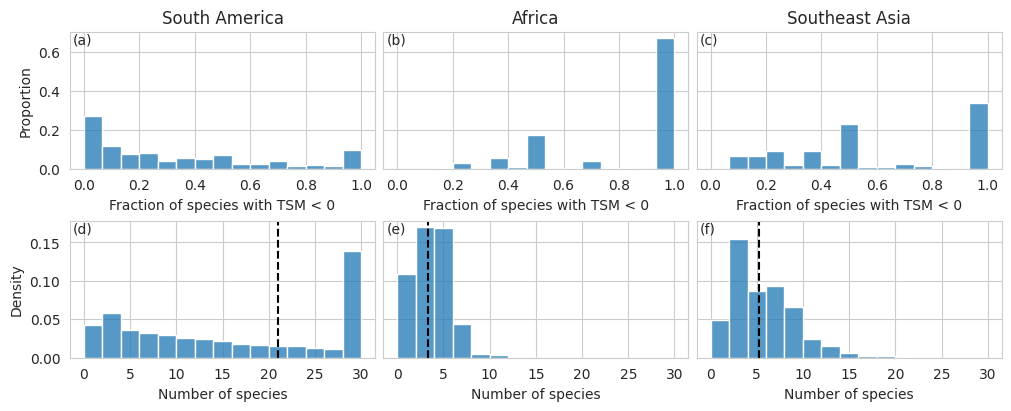

In [67]:
fig, (axs_top, axs_bottom) = plt.subplots(2,3, sharex='row', sharey='row', figsize=(10,4), layout='constrained')

xlims = [0, 10000, 21000, 32198]

for i, (ax1, ax2, title, abc1, abc2) in enumerate(zip(axs_top, axs_bottom, ['South America', 'Africa', 'Southeast Asia'], ['(a)','(b)','(c)'], ['(d)','(e)','(f)'])):
    sns.histplot(pd.Series(frac_sps_neg_tsm['2020'][:,xlims[i]:xlims[i+1]][frac_sps_neg_tsm['2020'][:,xlims[i]:xlims[i+1]]!=0]), 
                 bins=15, binrange=(0,1), stat='proportion', ax=ax1)
    
    sps_counts_data = sps_counts_dict['2020'][:, xlims[i]:xlims[i+1]][sps_counts_dict['2020'][:,xlims[i]:xlims[i+1]]!=0]
    sps_counts_capped = np.minimum(sps_counts_data, 30)
    sns.histplot(pd.Series(sps_counts_capped), bins=15, binrange=(0,30), stat='density', ax=ax2)
    mean_val = np.nanmean(sps_counts_data)
    print(mean_val)
    ax2.axvline(mean_val, color='black', linestyle='--', linewidth=1.5)
    ax1.set_title(title)
    ax1.set_xlabel('Fraction of species with TSM < 0')
    ax2.set_xlabel('Number of species')
    ax1.text(0.01, 0.99, abc1, transform=ax1.transAxes,fontsize=10, va='top', ha='left')
    ax2.text(0.01, 0.99, abc2, transform=ax2.transAxes,fontsize=10, va='top', ha='left')

plt.savefig("figures/resubmission/frac_species_neg_TSM_per_continent_hist.pdf", bbox_inches='tight')